In [1]:
import geopandas as gpd
import numpy as np
from scipy.stats import weibull_min, chi2
import pandas as pd

# Read the fire data
gdf = gpd.read_file("nfdb/NFDB_point_20250519.shp")

# read in the historical fire management zones
zones = gpd.read_file("historical_fire_zones\Historical_Fire_Management_Zones.shp")

# Ensure both GeoDataFrames use the same CRS
gdf = gdf.to_crs(zones.crs)

# join the two GeoDataFrames
data = gpd.sjoin(gdf, zones, how="inner", predicate="within")

# drop the data in FMZ_DESIGN == 'Parks Zone'
data = data[data.FMZ_DESIGN != "Parks Zone"]

data.NFDBFIREID.duplicated().sum()

# show me the rows where NFDBFIREID is duplicated
duplicates = data[data.NFDBFIREID.duplicated(keep=False)]

# remove the duplicates
data = data[~data.NFDBFIREID.duplicated(keep="first")]

data = data[(data.CAUSE == "N") | (data.CAUSE == "U")]

# drop rows where the REP_DATE is null
joined = data[data.REP_DATE.notnull()]

# make a new column for whether the SIZE_HA is greater than 100\
joined["SIZE_HA_100"] = joined["SIZE_HA"].apply(lambda x: True if x > 100 else False)

# remove the rows with YEAR before 1975
joined = joined[joined.YEAR >= 1976]

# make dictionary to change values of FMZ_DESIGN
fmz_dict = {
    "Hudson Bay Zone": "Extensive",
    "Great Lakes/St. Lawrence Zone": "Intensive Measured",
    "Boreal Zone": "Intensive Measured",
    "Northern Boreal Zone": "Intensive Measured"
}

# make a new column in the joined GeoDataFrame
joined["FMZ_ZONE"] = joined["FMZ_DESIGN"].map(fmz_dict)

season_dict = {1: "Winter",
               2: "Winter",
               3: "Spring",
                4: "Spring",
                5: "Spring",
                6: "Summer",
                7: "Summer",
                8: "Summer",
                9: "Fall",
                10: "Fall",
                11: "Fall",
                12: "Winter"}

# make a new column for the season based on the column called "MONTH"
joined["SEASON"] = joined["MONTH"].map(season_dict)


# make a new column based on the column year which is whether it is after 2006 or not
def after_2005(year):
    if year > 2005:
        return "After 2005"
    else:
        return "Before 2005"

joined["AFTER_2005"] = joined["YEAR"].apply(after_2005)

joined = joined[['YEAR', 'REP_DATE', 'SIZE_HA', 'FMZ_ZONE', 'SEASON', 'AFTER_2005', 'SIZE_HA_100']]

# make a table for the total area burned by year with another column as the number of fires and the number of fires greater than 100 ha
joined_grouped = joined.groupby(['YEAR']).agg(
    {'SIZE_HA': 'sum'}).reset_index()

# now make the same columns by for the fires in the Intensive Measured zone
joined_grouped_intensive = joined[joined.FMZ_ZONE == "Intensive Measured"].groupby(['YEAR']).agg(
    {'REP_DATE':'count', 'SIZE_HA_100': 'sum'}).reset_index()

# rename the columns
joined_grouped_intensive = joined_grouped_intensive.rename(
    columns={'REP_DATE': 'Number of Fires in the IM Zones', 'SIZE_HA_100': 'Number of Large Fires in the IM Zones'})

# do the same for the Extensive zone
joined_grouped_extensive = joined[joined.FMZ_ZONE == "Extensive"].groupby(['YEAR']).agg(
    {'REP_DATE':'count', 'SIZE_HA_100': 'sum'}).reset_index()

# rename the columns
joined_grouped_extensive = joined_grouped_extensive.rename(
    columns={'REP_DATE': 'Number of Fires in the Ext Zones', 'SIZE_HA_100': 'Number of Large Fires in the Ext Zones'})

# now merge the two dataframes
joined_grouped = pd.merge(joined_grouped, joined_grouped_intensive, on='YEAR', how='left')

# now merge the two dataframes

joined_grouped = pd.merge(joined_grouped, joined_grouped_extensive, on='YEAR', how='left')

joined_grouped

c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,YEAR,SIZE_HA,Number of Fires in the IM Zones,Number of Large Fires in the IM Zones,Number of Fires in the Ext Zones,Number of Large Fires in the Ext Zones
0,1976,457468.201016,1849,54,106,52
1,1977,387769.998153,474,12,58,32
2,1978,3655.700003,161,2,5,2
3,1979,59955.099868,627,16,29,10
4,1980,262433.598454,725,40,42,13
5,1981,137685.701306,412,10,64,38
6,1982,1683.499995,236,2,7,1
7,1983,426824.698229,946,29,113,50
8,1984,107222.703304,266,2,26,13
9,1985,142.400001,161,0,4,0


In [ ]:
# Step 3: Calculate the mean and variance of the simulated counts

# Observed Yearly Data

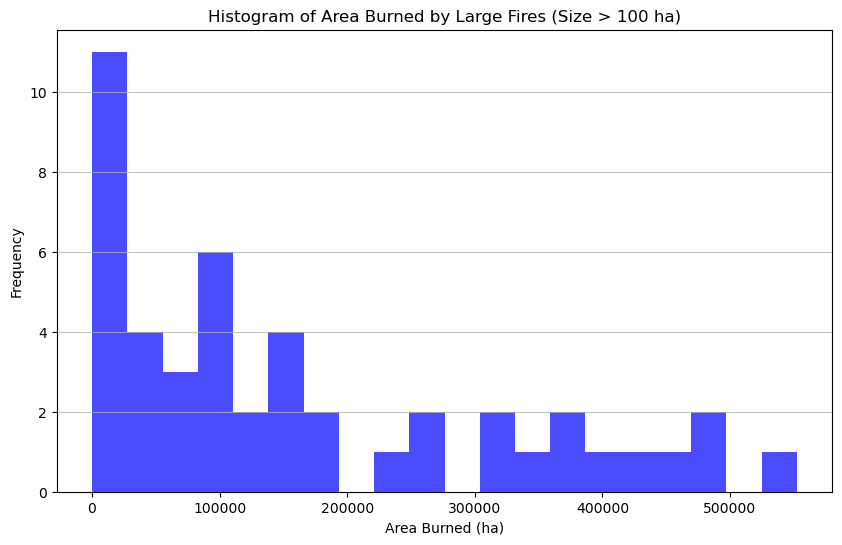

In [115]:
# make histograms of the yearly burned by large fires

# select only the fires that are greater than 100 ha
joined_large = joined[joined.SIZE_HA > 100]

# create a table for the total area burned by year with another column as the number of fires greater than 100 ha
joined_large_grouped = joined_large.groupby(['YEAR']).agg(
    {'SIZE_HA': 'sum', 'REP_DATE': 'count'}).reset_index()

joined_large_grouped

# make a histogram of the SIZE_HA column
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(joined_large_grouped['SIZE_HA'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Area Burned by Large Fires (Size > 100 ha)')
plt.xlabel('Area Burned (ha)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()



In [82]:
joined_large_grouped


,YEAR,SIZE_HA,REP_DATE
0,1976,453102.700974,106
1,1977,386409.798149,44
2,1978,3316.400002,4
3,1979,58590.699852,26
4,1980,260215.298447,53
5,1981,136794.401299,48
6,1982,1434.599991,3
7,1983,424354.298210,79
8,1984,106968.103302,15
9,1986,138927.500000,18


In [69]:
# what percentage of area burned is from large fires
total_area_burned = joined_grouped['SIZE_HA'].sum()
large_area_burned = joined_large_grouped['SIZE_HA'].sum()

percentage_large_fires = (large_area_burned / total_area_burned) * 100
print(f"Percentage of area burned by large fires (Size > 100 ha): {percentage_large_fires:.2f}%")

Percentage of area burned by large fires (Size > 100 ha): 98.99%


# Fit Distribution to Fire Sizes

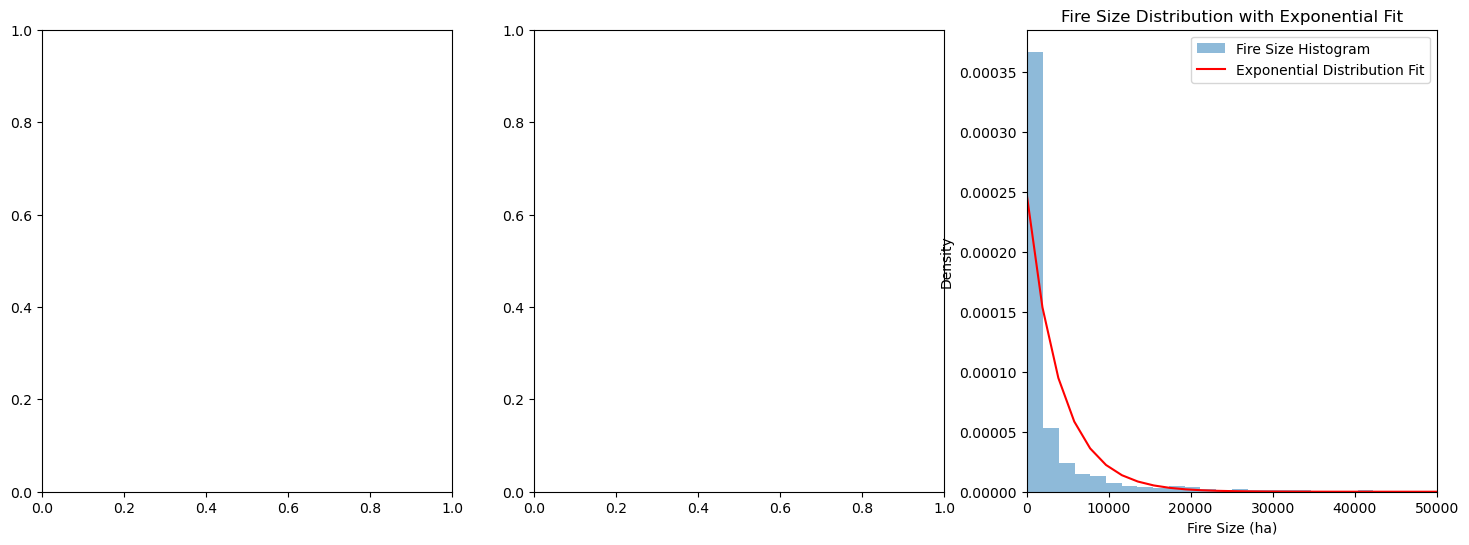

c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\scipy\stats\_continuous_distns.py:2757: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


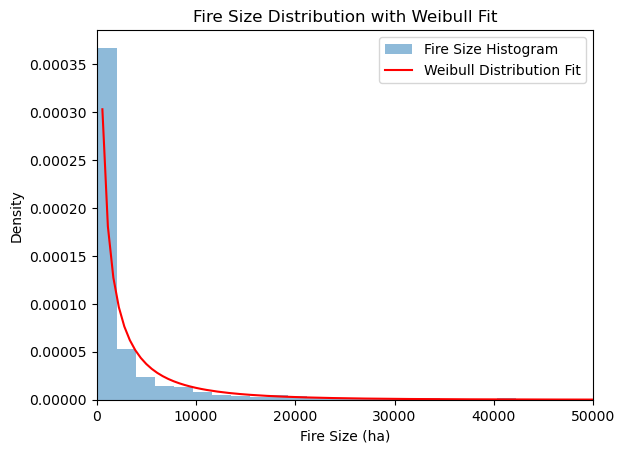

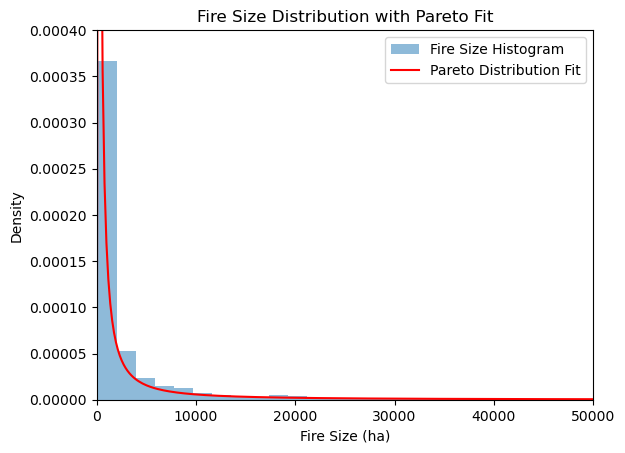

In [165]:
# get the average fire size to fit an expnential distribution
average_fire_size = joined_large['SIZE_HA'].mean()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# graph the exponential distribtuion over the histogram of the fire sizes
from scipy.stats import expon
# create a range of x values for the exponential distribution
x_exp = np.linspace(0, joined_large['SIZE_HA'].max(), 100)
# calculate the PDF of the exponential distribution
pdf_exp = expon.pdf(x_exp, scale=average_fire_size)
# plot the histogram of fire sizes and the fitted exponential distribution
plt.hist(joined_large['SIZE_HA'], bins=100, density=True, alpha=0.5, label='Fire Size Histogram')
plt.plot(x_exp, pdf_exp, 'r-', label='Exponential Distribution Fit')
plt.xlabel('Fire Size (ha)')
plt.ylabel('Density')
plt.xlim(0, 50000)
plt.title('Fire Size Distribution with Exponential Fit')
plt.legend()
plt.show()

# fit a weibull distribution to the fire sizes
shape_weibull, loc_weibull, scale_weibull = weibull_min.fit(joined_large['SIZE_HA'], floc=0)
# create a range of x values for the fitted distribution
x = np.linspace(0, joined_large_grouped['SIZE_HA'].max(), 1000)
# calculate the PDF of the fitted Weibull distribution
pdf = weibull_min.pdf(x, shape_weibull, loc=loc_weibull, scale=scale_weibull)
# plot the histogram of fire sizes and the fitted Weibull distribution
plt.hist(joined_large['SIZE_HA'], bins=100, density=True, alpha=0.5, label='Fire Size Histogram')
plt.plot(x, pdf, 'r-', label='Weibull Distribution Fit')
plt.xlabel('Fire Size (ha)')
plt.ylabel('Density')
plt.xlim(0, 50000)
plt.title('Fire Size Distribution with Weibull Fit')
plt.legend()
plt.show()


# fit a pareto distribution to the fire sizes
from scipy.stats import pareto
shape_pareto, loc_pareto, scale_pareto = pareto.fit(joined_large['SIZE_HA'], floc=0)
# create a range of x values for the fitted distribution
x_pareto = np.linspace(0, joined_large['SIZE_HA'].max(), 1000)
# calculate the PDF of the fitted Pareto distribution
pdf_pareto = pareto.pdf(x_pareto, shape_pareto, loc=loc_pareto, scale=scale_pareto)
# plot the histogram of fire sizes and the fitted Pareto distribution
plt.hist(joined_large['SIZE_HA'], bins=100, density=True, alpha=0.5, label='Fire Size Histogram')
plt.plot(x_pareto, pdf_pareto, 'r-', label='Pareto Distribution Fit')
plt.xlabel('Fire Size (ha)')
plt.ylabel('Density')
plt.xlim(0, 50000)
plt.ylim(0, 0.0004)
plt.title('Fire Size Distribution with Pareto Fit')
plt.legend()
plt.show()

# combine these three distributions into a side by side plot





# Cox Process for Yearly Fire Counts

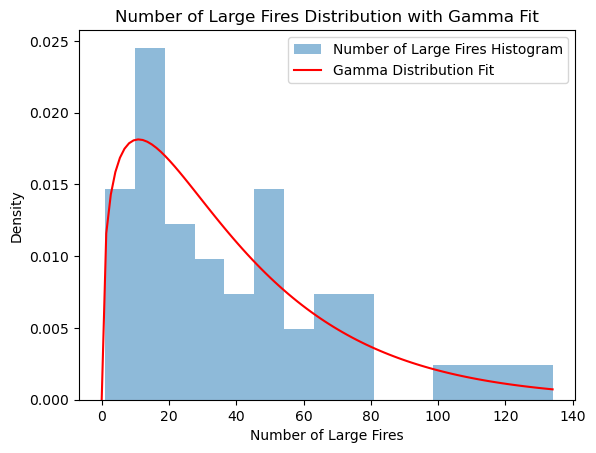

In [ ]:
# fit a distribution to the number of large fires, use gamma

from scipy.stats import gamma
# Fit a gamma distribution to the number of large fires
shape_gamma, loc_gamma, scale_gamma = gamma.fit(joined_large_grouped['REP_DATE'], floc=0)

# Create a range of x values for the fitted distribution
x_gamma = np.linspace(0, joined_large_grouped['REP_DATE'].max(), 100)

# Calculate the PDF of the fitted gamma distribution
pdf_gamma = gamma.pdf(x_gamma, shape_gamma, loc=loc_gamma, scale=scale_gamma)

# Plot the histogram of the number of large fires and the fitted gamma distribution
plt.hist(joined_large_grouped['REP_DATE'], bins=15, density=True, alpha=0.5, label='Number of Large Fires Histogram')

plt.plot(x_gamma, pdf_gamma, 'r-', label='Gamma Distribution Fit')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.title('Number of Large Fires Distribution with Gamma Fit')
plt.legend()
plt.show()


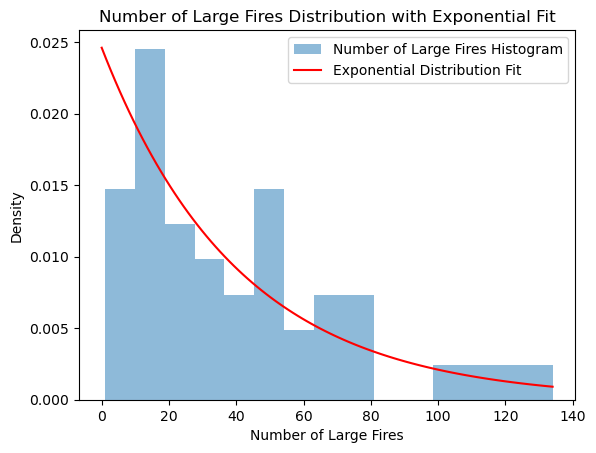

In [149]:
# try fitting the counts or large fires with an exponential distribution
from scipy.stats import expon
scale_expon = joined_large_grouped['REP_DATE'].mean()
# Create a range of x values for the fitted distribution
x_expon = np.linspace(0, joined_large_grouped['REP_DATE'].max(), 100)
# Calculate the PDF of the fitted exponential distribution
pdf_expon = expon.pdf(x_expon, scale=scale_expon)
# Plot the histogram of the number of large fires and the fitted exponential distribution
plt.hist(joined_large_grouped['REP_DATE'], bins=15, density=True, alpha=0.5, label='Number of Large Fires Histogram')
plt.plot(x_expon, pdf_expon, 'r-', label='Exponential Distribution Fit')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.title('Number of Large Fires Distribution with Exponential Fit')
plt.legend()
plt.show()


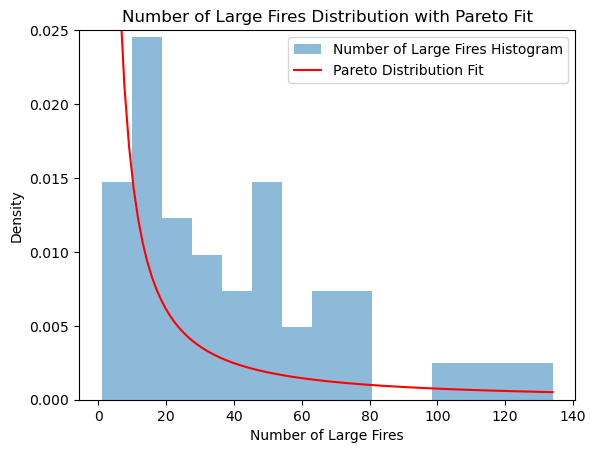

In [159]:
# do the same thing with a pareto distribution
from scipy.stats import pareto
shape_pareto_counts, loc_pareto_counts, scale_pareto_counts = pareto.fit(joined_large_grouped['REP_DATE'], floc=0)
# Create a range of x values for the fitted distribution
x_pareto_counts = np.linspace(1, joined_large_grouped['REP_DATE'].max(), 100)
# Calculate the PDF of the fitted Pareto distribution
pdf_pareto_counts = pareto.pdf(x_pareto_counts, shape_pareto_counts, loc=loc_pareto_counts, scale=scale_pareto_counts)
# Plot the histogram of the number of large fires and the fitted Pareto distribution
plt.hist(joined_large_grouped['REP_DATE'], bins=15, density=True, alpha=0.5, label='Number of Large Fires Histogram')
plt.plot(x_pareto_counts, pdf_pareto_counts, 'r-', label='Pareto Distribution Fit')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.ylim(0, 0.025)
plt.title('Number of Large Fires Distribution with Pareto Fit')
plt.legend()
plt.show()

# Generate Fire Counts

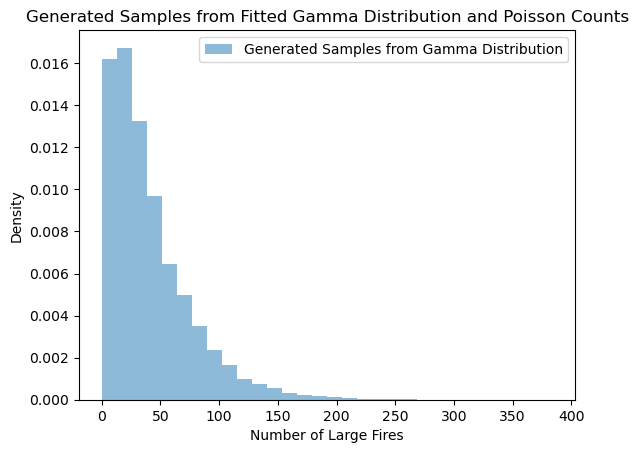

In [138]:
# generate number of fires with the fitted gamma distribution
num_samples = 100000
simulated_lambdas = gamma.rvs(shape_gamma, loc=loc_gamma, scale=scale_gamma, size=num_samples)
# create simulated counts of large fires based on the lambda values
simulated_counts = np.random.poisson(simulated_lambdas)

# Create a histogram of the generated samples
plt.hist(simulated_counts, bins=30, density=True, alpha=0.5, label='Generated Samples from Gamma Distribution')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.title('Generated Samples from Fitted Gamma Distribution and Poisson Counts')
plt.legend()
plt.show()

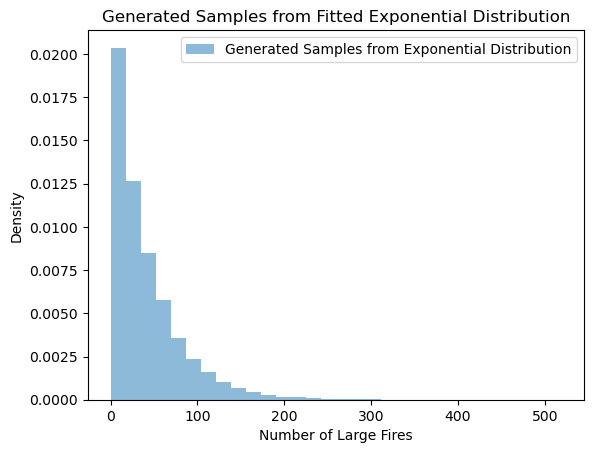

In [151]:
# make simulated exponential counts
simulated_lambdas = np.random.exponential(scale=scale_expon, size=num_samples)

simulated_counts_exponential = np.random.poisson(simulated_lambdas)
# Create a histogram of the generated samples
plt.hist(simulated_counts_exponential, bins=30, density=True, alpha=0.5, label='Generated Samples from Exponential Distribution')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.title('Generated Samples from Fitted Exponential Distribution')
plt.legend()
plt.show()


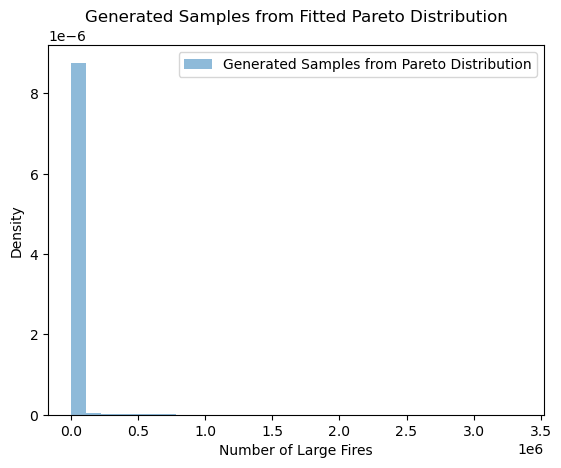

In [163]:
# make simulated pareto counts
simulated_lambdas_pareto = pareto.rvs(shape_pareto_counts, loc=loc_pareto_counts, scale=scale_pareto_counts, size=num_samples)
# drop top 1% of the simulated lambdas to avoid extreme values
simulated_lambdas_pareto = np.sort(simulated_lambdas_pareto)[:int(0.99 * num_samples)]
simulated_counts_pareto = np.random.poisson(simulated_lambdas_pareto)
# Create a histogram of the generated samples
plt.hist(simulated_counts_pareto, bins=30, density=True, alpha=0.5, label='Generated Samples from Pareto Distribution')
plt.xlabel('Number of Large Fires')
plt.ylabel('Density')
plt.title('Generated Samples from Fitted Pareto Distribution')
plt.legend()
plt.show()

np.float64(4612131952095012.0)

# Generate Total Area Burned   

In [139]:
# make a function that given a number of fires, generate that many fires then return the total area burned
def generate_fire_area_exponential(num_fires, mean_fire_size):
    # generate fire sizes using an exponential distribution
    fire_sizes = np.random.exponential(scale=mean_fire_size, size=num_fires)
    
    # Return the total area burned
    return np.sum(fire_sizes)

def generate_fire_area_weibull(num_fires, scale, shape, loc):
    # generate fire sizes using an weibull distribution
    fire_sizes = weibull_min.rvs(shape, loc=loc, scale=scale, size=num_fires)
    
    # Return the total area burned
    return np.sum(fire_sizes)

def generate_fire_area_pareto(num_fires, shape, scale, loc):
    # generate fire sizes using a pareto distribution
    fire_sizes = pareto.rvs(shape, loc=loc, scale=scale, size=num_fires)
    
    # Return the total area burned
    return np.sum(fire_sizes)

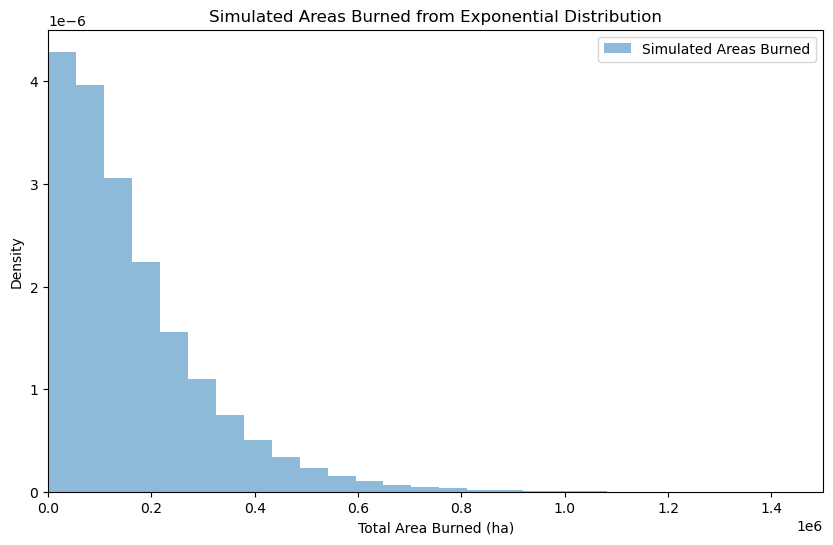

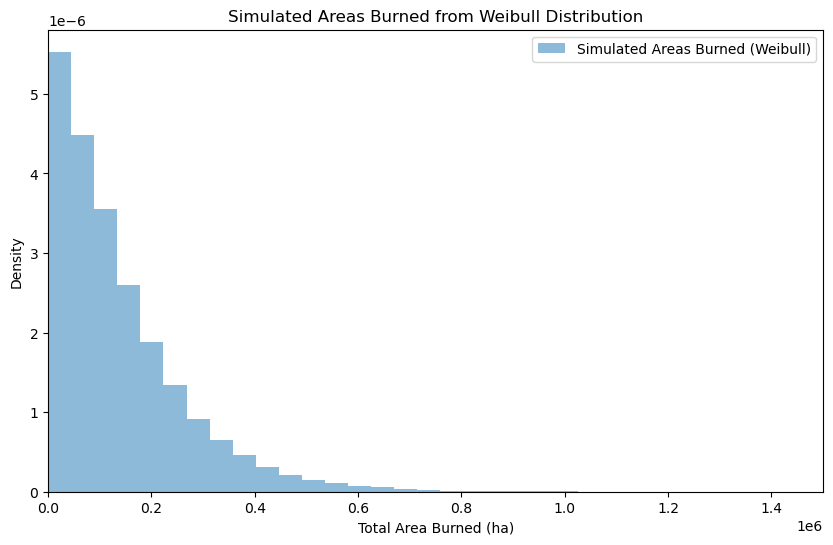

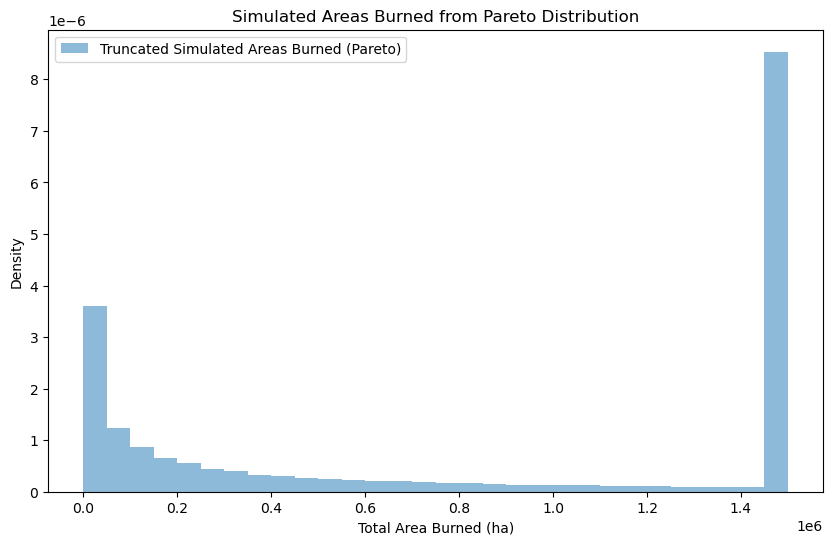

In [141]:
# apply exponential function to the simulated counts
simulated_areas = [generate_fire_area_exponential(int(count), average_fire_size) for count in simulated_counts]

# Create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Exponential Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()

# apply weibull function to the simulated counts
simulated_areas_weibull = [generate_fire_area_weibull(int(count), scale_weibull, shape_weibull, loc_weibull) for count in simulated_counts]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_weibull, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned (Weibull)')
plt.xlim(0, 1500000)
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Weibull Distribution')
plt.legend()
plt.show()

# apply pareto function to the simulated counts
simulated_areas_pareto = [generate_fire_area_pareto(int(count), shape_pareto, scale_pareto, loc_pareto) for count in simulated_counts]
# truncate to 1500000 ha
simulated_areas_pareto = [area if area < 1500000 else 1500000 for area in simulated_areas_pareto]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_pareto, bins=30, density=True, alpha=0.5, label='Truncated Simulated Areas Burned (Pareto)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Pareto Distribution')
plt.legend()
plt.show()



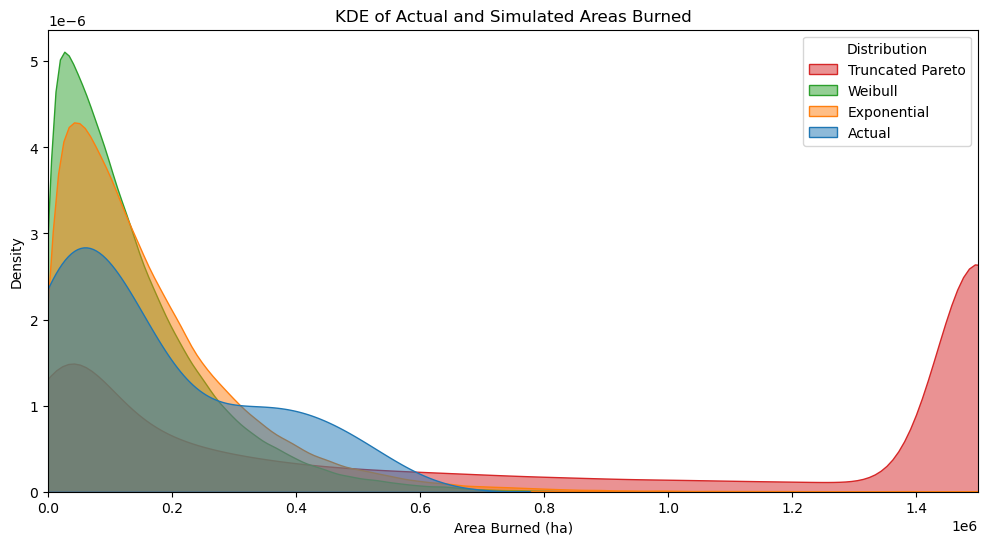

In [142]:
# use seaborn to make kde of each of the simulated over the actual
import seaborn as sns
# Create a DataFrame for the simulated areas
simulated_df = pd.DataFrame({
    'Exponential': simulated_areas,
    'Weibull': simulated_areas_weibull,
    'Pareto': simulated_areas_pareto
})

# Create a DataFrame for the actual areas burned
actual_df = pd.DataFrame({
    'Actual': joined_large_grouped['SIZE_HA']
})

# Combine the actual and simulated data for plotting
combined_df = pd.concat([actual_df, simulated_df], axis=1)
# Melt the DataFrame for seaborn
melted_df = combined_df.melt(var_name='Distribution', value_name='Area Burned').dropna()
# Create a KDE plot using seaborn
plt.figure(figsize=(12, 6))
order = ['Actual', 'Exponential', 'Weibull', 'Pareto']
sns.kdeplot(data=melted_df, x='Area Burned', hue='Distribution', hue_order=order, fill=True, common_norm=False, alpha=0.5)
plt.title('KDE of Actual and Simulated Areas Burned')
plt.xlabel('Area Burned (ha)')
plt.ylabel('Density')
plt.xlim(0, 1500000)
# add legend labeling each distribution
plt.legend(title='Distribution', labels=['Truncated Pareto', 'Weibull', 'Exponential', 'Actual'])
plt.show()


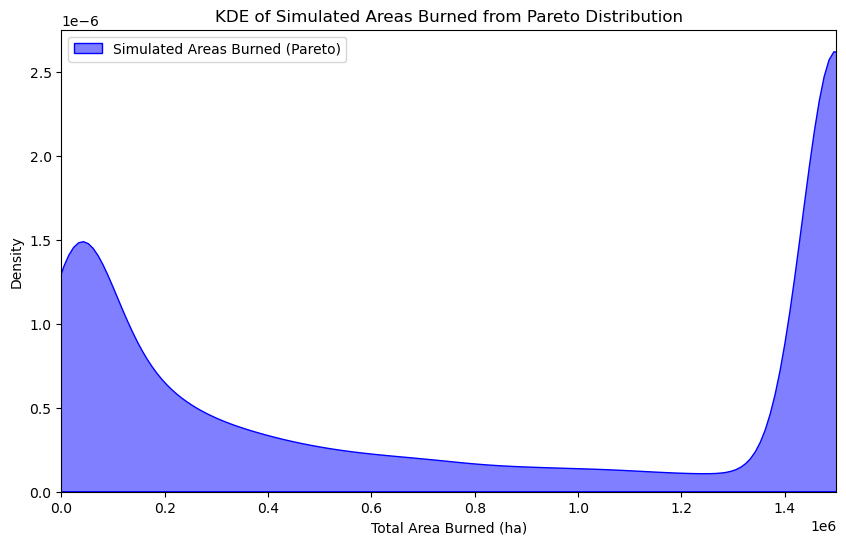

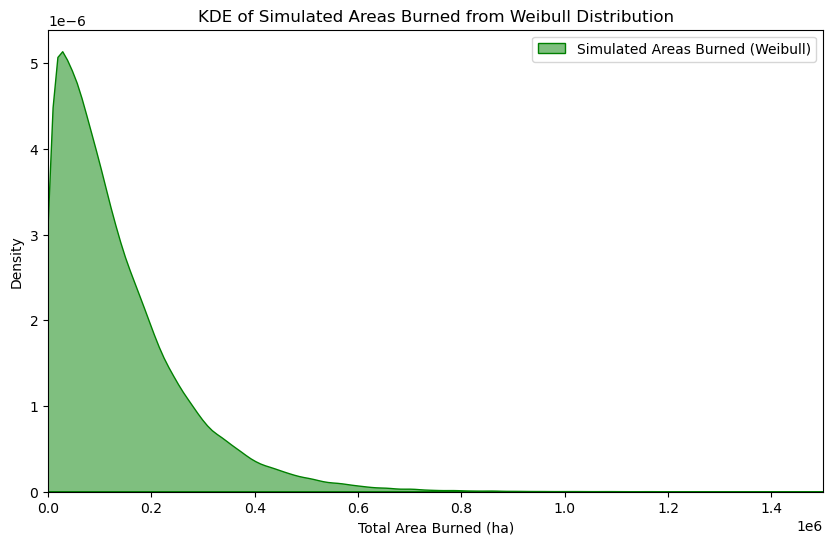

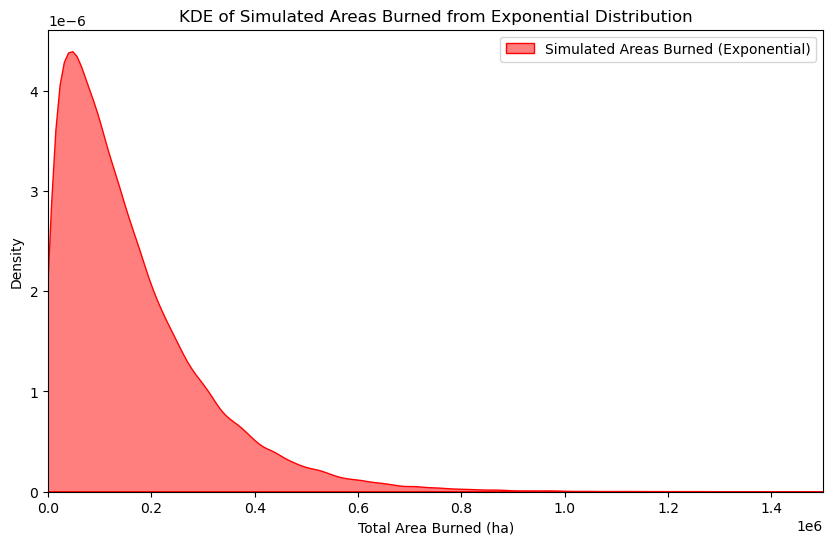

In [133]:
# make kde of the pareto
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_areas_pareto, fill=True, color='blue', alpha=0.5, label='Simulated Areas Burned (Pareto)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('KDE of Simulated Areas Burned from Pareto Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()

# make kde of the weibull
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_areas_weibull, fill=True, color='green', alpha=0.5, label='Simulated Areas Burned (Weibull)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('KDE of Simulated Areas Burned from Weibull Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()

# make kde of the exponential
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_areas, fill=True, color='red', alpha=0.5, label='Simulated Areas Burned (Exponential)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('KDE of Simulated Areas Burned from Exponential Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()



# simulated fires with exponential cox process

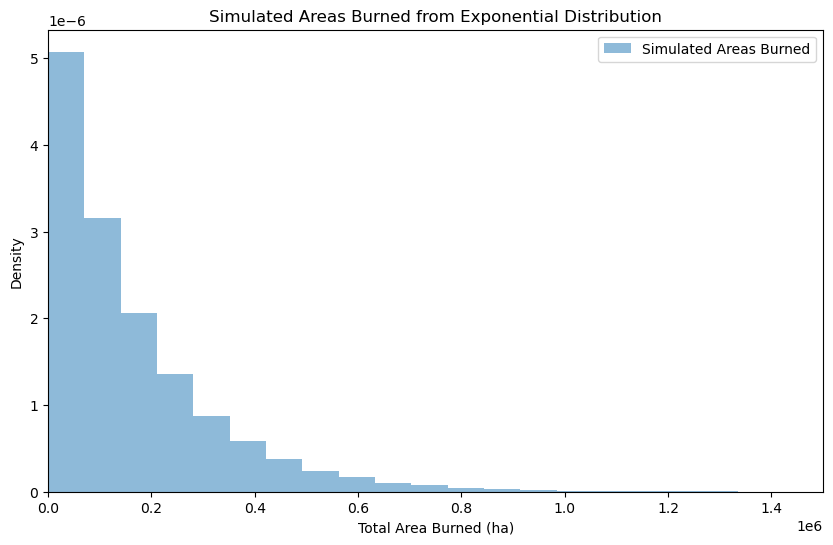

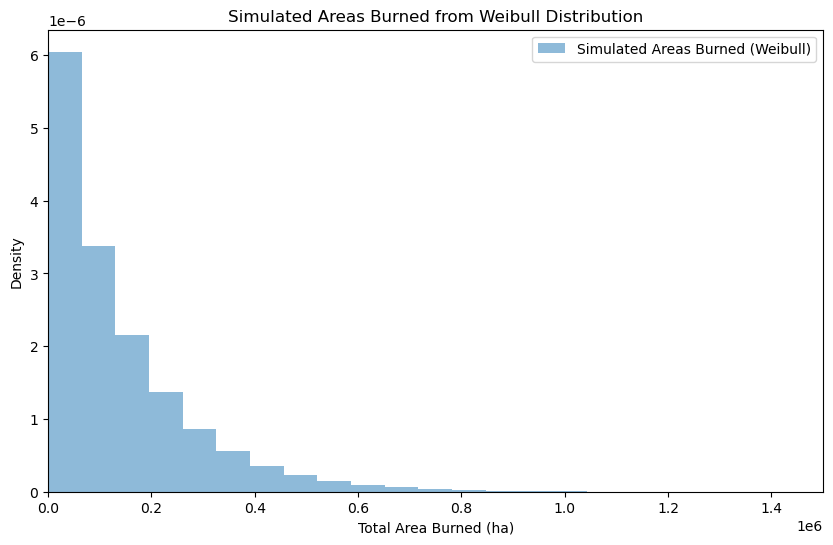

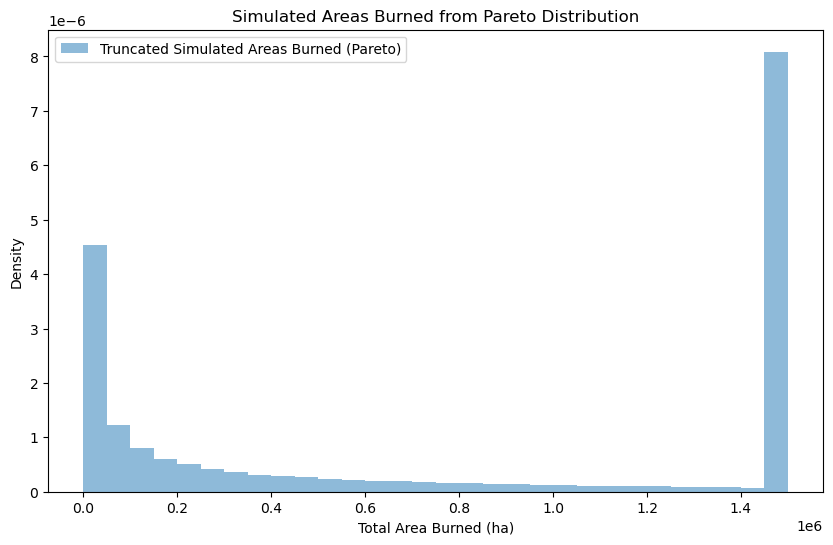

In [152]:
# apply exponential function to the simulated counts
simulated_areas = [generate_fire_area_exponential(int(count), average_fire_size) for count in simulated_counts_exponential]

# Create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Exponential Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()

# apply weibull function to the simulated counts
simulated_areas_weibull = [generate_fire_area_weibull(int(count), scale_weibull, shape_weibull, loc_weibull) for count in simulated_counts_exponential]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_weibull, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned (Weibull)')
plt.xlim(0, 1500000)
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Weibull Distribution')
plt.legend()
plt.show()

# apply pareto function to the simulated counts
simulated_areas_pareto = [generate_fire_area_pareto(int(count), shape_pareto, scale_pareto, loc_pareto) for count in simulated_counts_exponential]
# truncate to 1500000 ha
simulated_areas_pareto = [area if area < 1500000 else 1500000 for area in simulated_areas_pareto]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_pareto, bins=30, density=True, alpha=0.5, label='Truncated Simulated Areas Burned (Pareto)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Pareto Distribution')
plt.legend()
plt.show()

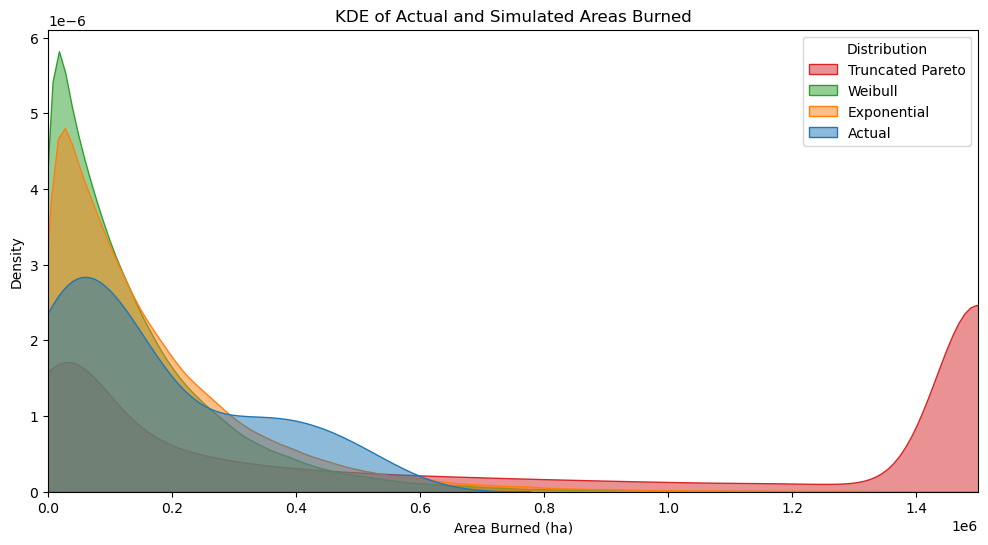

In [153]:
# use seaborn to make kde of each of the simulated over the actual
import seaborn as sns
# Create a DataFrame for the simulated areas
simulated_df = pd.DataFrame({
    'Exponential': simulated_areas,
    'Weibull': simulated_areas_weibull,
    'Pareto': simulated_areas_pareto
})

# Create a DataFrame for the actual areas burned
actual_df = pd.DataFrame({
    'Actual': joined_large_grouped['SIZE_HA']
})

# Combine the actual and simulated data for plotting
combined_df = pd.concat([actual_df, simulated_df], axis=1)
# Melt the DataFrame for seaborn
melted_df = combined_df.melt(var_name='Distribution', value_name='Area Burned').dropna()
# Create a KDE plot using seaborn
plt.figure(figsize=(12, 6))
order = ['Actual', 'Exponential', 'Weibull', 'Pareto']
sns.kdeplot(data=melted_df, x='Area Burned', hue='Distribution', hue_order=order, fill=True, common_norm=False, alpha=0.5)
plt.title('KDE of Actual and Simulated Areas Burned')
plt.xlabel('Area Burned (ha)')
plt.ylabel('Density')
plt.xlim(0, 1500000)
# add legend labeling each distribution
plt.legend(title='Distribution', labels=['Truncated Pareto', 'Weibull', 'Exponential', 'Actual'])
plt.show()


# simulated fires with Pareto cox Process

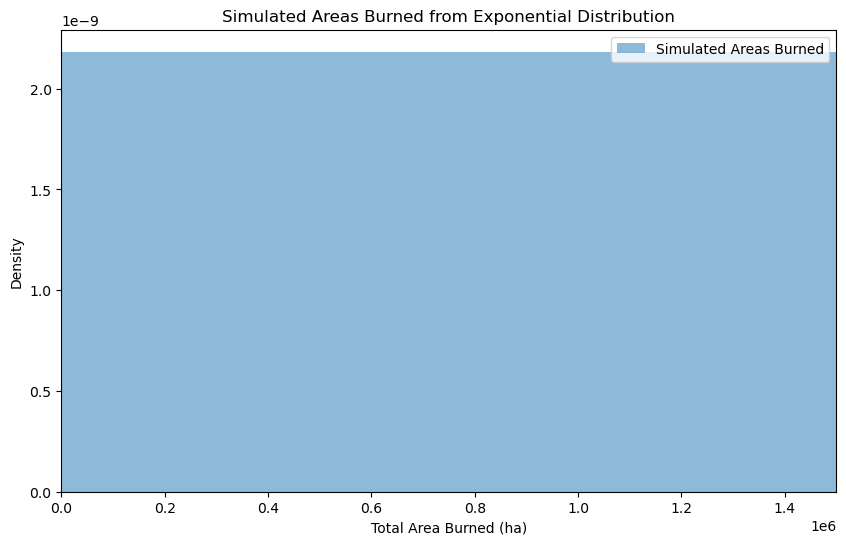

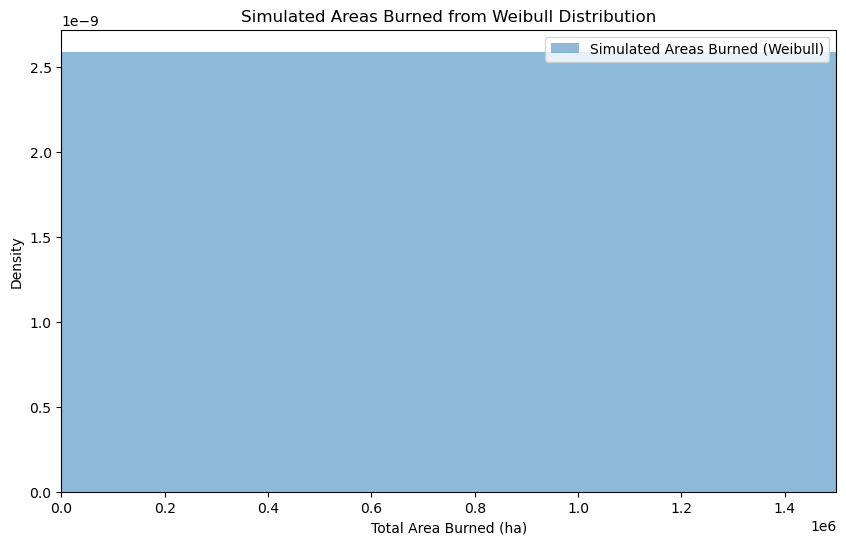

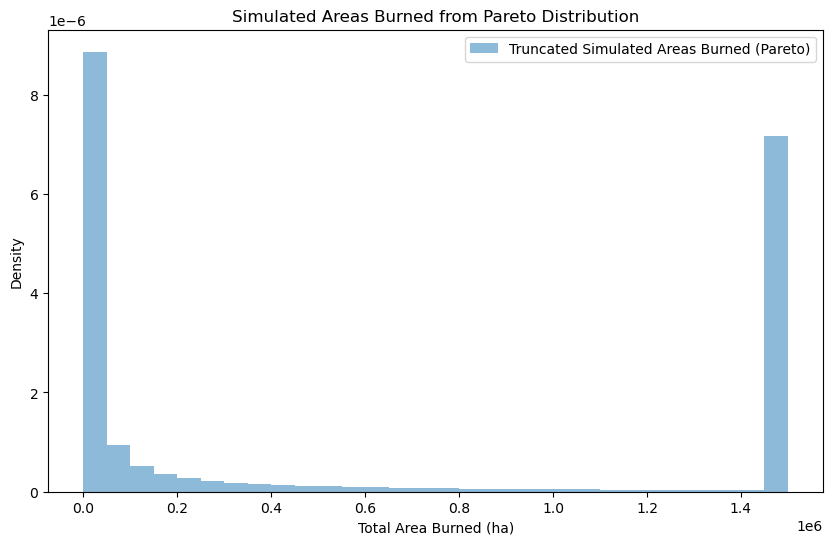

In [164]:
# apply exponential function to the simulated counts
simulated_areas = [generate_fire_area_exponential(int(count), average_fire_size) for count in simulated_counts_pareto]

# truncate areas to 1500000 ha
simulated_areas = [area if area < 1500000 else 1500000 for area in simulated_areas]

# Create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Exponential Distribution')
plt.xlim(0, 1500000)
plt.legend()
plt.show()

# apply weibull function to the simulated counts
simulated_areas_weibull = [generate_fire_area_weibull(int(count), scale_weibull, shape_weibull, loc_weibull) for count in simulated_counts_pareto]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_weibull, bins=30, density=True, alpha=0.5, label='Simulated Areas Burned (Weibull)')
plt.xlim(0, 1500000)
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Weibull Distribution')
plt.legend()
plt.show()

# apply pareto function to the simulated counts
simulated_areas_pareto = [generate_fire_area_pareto(int(count), shape_pareto, scale_pareto, loc_pareto) for count in simulated_counts_pareto]
# truncate to 1500000 ha
simulated_areas_pareto = [area if area < 1500000 else 1500000 for area in simulated_areas_pareto]
# create a histogram of the simulated areas burned
plt.figure(figsize=(10, 6))
plt.hist(simulated_areas_pareto, bins=30, density=True, alpha=0.5, label='Truncated Simulated Areas Burned (Pareto)')
plt.xlabel('Total Area Burned (ha)')
plt.ylabel('Density')
plt.title('Simulated Areas Burned from Pareto Distribution')
plt.legend()
plt.show()

# testing independence of fire size and fire count

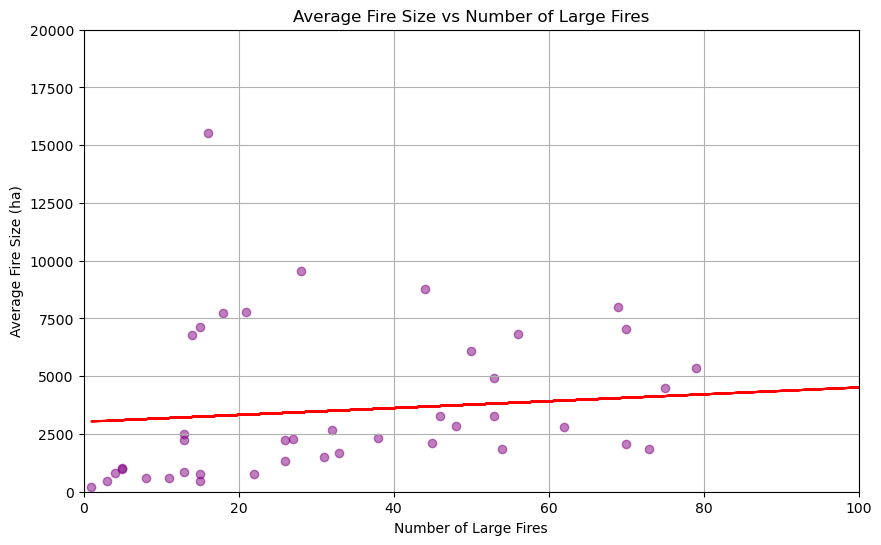

In [147]:
# get average fire size for each year and the number of fires, do this for the large fires
joined_large_grouped['Average Fire Size'] = joined_large_grouped['SIZE_HA'] / joined_large_grouped['REP_DATE']

joined_large_grouped

# scatter plot of the REP_DATE vs Average Fire Size
plt.figure(figsize=(10, 6))
plt.scatter(joined_large_grouped['REP_DATE'], joined_large_grouped['Average Fire Size'], alpha=0.5, color='purple')
plt.xlabel('Number of Large Fires')
plt.ylabel('Average Fire Size (ha)')
plt.title('Average Fire Size vs Number of Large Fires')
# add a line of best fit 
z = np.polyfit(joined_large_grouped['REP_DATE'], joined_large_grouped['Average Fire Size'], 1)
p = np.poly1d(z)
plt.plot(joined_large_grouped['REP_DATE'], p(joined_large_grouped['REP_DATE']), color='red', label='Line of Best Fit')
plt.xlim(0, 100)
plt.ylim(0, 20000)
plt.grid()
plt.show()

